# Optimize segmentation algorithms

The Napari plugin [napari-workflow-optimizer](https://github.com/haesleinhuepf/napari-workflow-optimizer) allows optimizing image segmentation workflows in a convenient way.

In [1]:
from napari_workflow_optimizer import JaccardLabelImageOptimizer, Workflow

from skimage.io import imread
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

To use the optimizer, we need to define our workflow using a `Workflow` object. It works like a dictionary with image names as keywords and list of operations and parameters as values. The underlying infrastructure is based on [dask graphs](https://docs.dask.org/en/stable/graphs.html).

In [2]:
w = Workflow()
# define background subtraction
w.set("blurred", cle.gaussian_blur, "input", sigma_x=5, sigma_y=5)
# define segmentation
w.set("binarized", cle.threshold_otsu, "blurred")
w.set("labeled", cle.label, "binarized")

These workflows can be explored. For example we can read from it which image parameters are needed to get started.

In [3]:
w.roots()

['input']

We can also determine what the result images of the workflow are.

In [4]:
w.leafs()

['labeled']

After setting the inputs, we can ask the workflow to compute results.

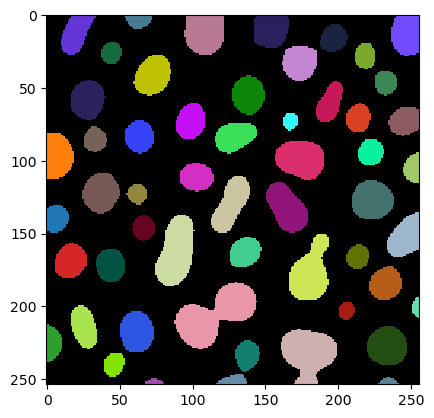

In [5]:
w.set("input", imread("../../data/blobs.tif"))
result = w.get("labeled")

cle.imshow(result, labels=True)

For optimization of such a workflow, we need a ground truth annotation image. A sparse annotation of some objects is enough for this.

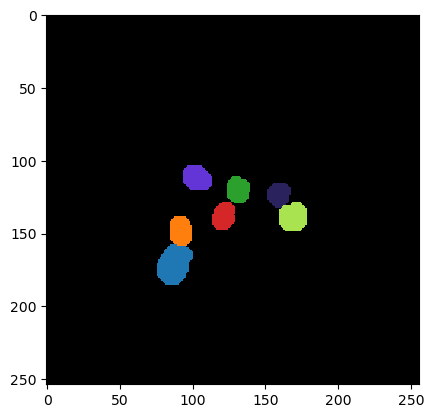

In [6]:
ground_truth = imread("../../data/blobs_sparse_labels.tif")
cle.imshow(ground_truth, labels=True)

The `JaccardLabelImageOptimizer` consumes a workflow and can optimize parameters with respect to a sparse ground truth. Its `optimize` function returns a set of parameters which corresponds to all numeric parameters of the workflow.

In [7]:
jlio = JaccardLabelImageOptimizer(w)
best_param = jlio.optimize("labeled", ground_truth, maxiter=20)
best_param

array([4.80023582e+00, 4.44562637e+00, 3.84861161e-04])

We can then use the optimizer for setting these parameters to the workflow and afterwards read where in the workflow the paramweters were set.

In [8]:
jlio.set_numeric_parameters(best_param)

# before printing the workflow, we quickly remove the input image
w.remove('input')
print(w)

Workflow:
blurred <- (<function gaussian_blur at 0x0000023723085A60>, 'input', None, 4.8002358210977345, 4.445626372447739, 0.00038486116050511713)
binarized <- (<function threshold_otsu at 0x00000237232EADC0>, 'blurred')
labeled <- (<function connected_components_labeling_box at 0x000002372316AB80>, 'binarized')



After setting the input again, we can also apply the workflow to the image and inspect the result visually.

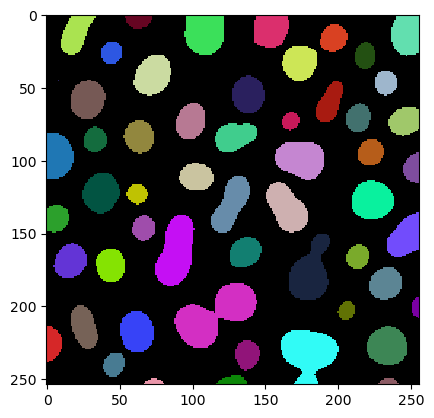

In [9]:
w.set("input", imread("../../data/blobs.tif"))
cle.imshow(w.get("labeled"), labels=True)

## Further insights in optimization

The `JaccardLabelImageOptimizer` also allows to take a look at the optimization process applied earlier.

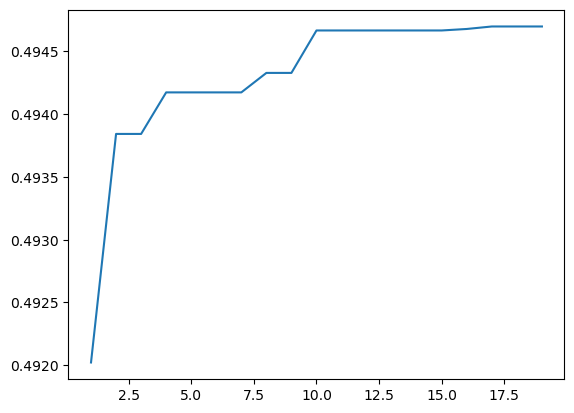

In [10]:
attempt, quality = jlio.get_plot()

plt.plot(attempt, quality)